# Image classification on [MNIST](https://yann.lecun.com/exdb/mnist/) dataset

_Handling Convolutional Neural Networks_

---


In this tutorial you will learn to : 
* Write multilayer perceptron and convolutional network with [`Keras`](https://keras.io/) and [`Tensorflow`](https://www.tensorflow.org/)
* Understand how `convolutional`, `max pooling`, `stride` and `padding` layers work.
* Use these models for image classification.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import time

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

In [5]:
import tensorflow as tf
tf.__version__

2024-10-02 14:15:54.902601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 14:15:54.922640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 14:15:54.928548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 14:15:54.942843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 14:15:58.184205: W tensorflow/comp

'2.17.0'

This code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [6]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

## Data exploration

The dataset that will be used in this TP is the [$\texttt{MNIST}$](http://yann.lecun.com/exdb/mnist/) database.<br>
It is composed of 70.000 images (60.000 for learning, 10.000 for test) of 28x28 pixels of handwritten digits from 0 to 9.<br>

These data are directly available on the `Keras` library.

In [9]:
from tensorflow.keras.datasets import mnist

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##### <i style="color:purple">**Todo:** Check that the images are the correct size, as well as the test and train sets.</i>

In [13]:
# %load solutions/MNIST/size.py
N_train, N_x_pixels, N_y_pixels = x_train.shape
N_test = x_test.shape[0]
N_classes = np.unique(y_train).shape[0]  #len(set(y_train))

print("Train data: %d images  (%d x %d pixels)" %(N_train, N_x_pixels, N_y_pixels))
print("Test data: %d images  (%d x %d pixels)" %(N_test, N_x_pixels, N_y_pixels))
print("Number of classes: %d classes" %N_classes)

Train data: 60000 images  (28 x 28 pixels)
Test data: 10000 images  (28 x 28 pixels)
Number of classes: 10 classes


In [11]:
# %load solutions/MNIST/size.py

##### <i style="color:purple">**Question:**  Is the dataset balanced?</i>

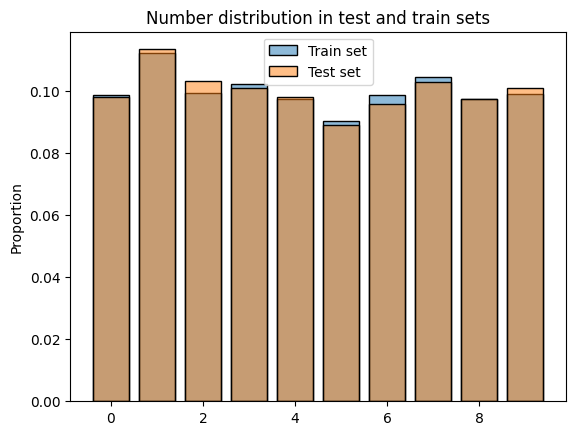

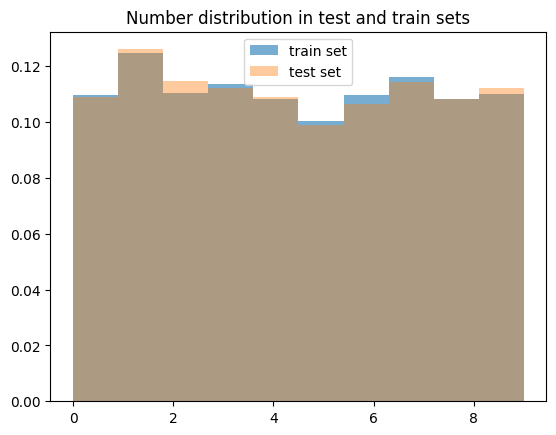

In [26]:
# %load solutions/MNIST/histograms.py
# Seaborn

plt.figure()
sns.histplot(y_train, stat='proportion', discrete=True, alpha=.5, shrink=.8, label='Train set')
sns.histplot(y_test, stat='proportion', discrete=True, alpha=.5, shrink=.8, label='Test set')

plt.title('Number distribution in test and train sets')
plt.legend()
plt.show()


# --- #
# Matplotlib

plt.figure()
plt.hist(y_train, density=True, alpha=0.6, label='train set')
plt.hist(y_test, density=True, alpha=0.4, label='test set')

plt.title('Number distribution in test and train sets')
plt.legend()
plt.show()

In [ ]:
# %load solutions/MNIST/histograms.py

### Data visualization

In [27]:
import random as rd

##### <i style="color:purple">**Todo:** View an example of each digit</i>

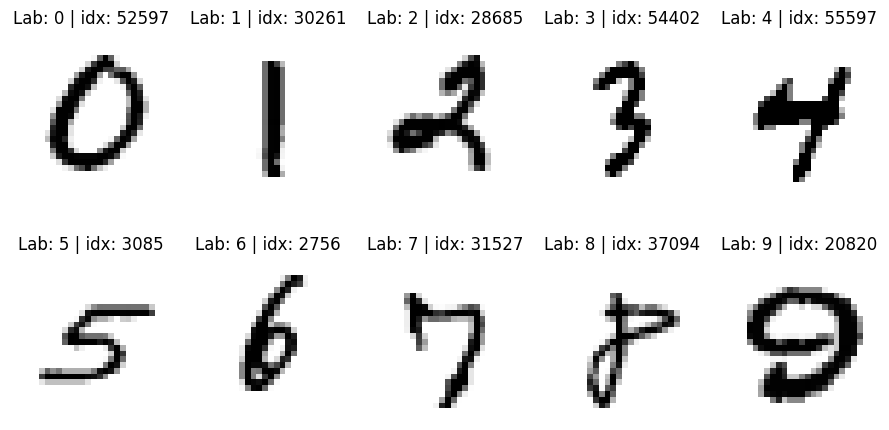

In [29]:
# %load solutions/MNIST/imshow.py
fig = plt.figure(figsize=(9, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    sample_index = rd.choice( np.where(y_train==i)[0] )
    ax.imshow(x_train[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
    # ax.set_title("Label: %d" % y_train[sample_index])
    ax.set_title("Lab: %d | idx: %d" % (y_train[sample_index], sample_index))
    ax.grid(False)
    ax.axis('off')
        
plt.tight_layout()
plt.show()

In [ ]:
# %load solutions/MNIST/imshow.py

## Image classification with Multi Layer Perceptron model.

We will first try to learn an image classifier with a MLP model with the following architecture.

* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 10 neurons (Number of classes ) and *softmax* activation function

### Data format

Some modifications are required on the data to use them with our model. 

The first layer is a Dense Layer, which handles 1D vectors as an input. We must first reshape the 2D $28\times28$ images as a 1D $28\times28=784$ vector. 
<!-- We take this opportunity to renormalize the image, _i.e._ divide all its values by $255$ (grayscale image). -->

In [30]:
x_train_flatten = x_train.reshape((N_train, N_x_pixels*N_y_pixels))
x_test_flatten = x_test.reshape((N_test, N_x_pixels*N_y_pixels))
N_dim_flatten = x_train_flatten.shape[1]

print("Dimensions of flatten train images: %d x %d" %(x_train_flatten.shape))
print("Dimensions of flatten test images: %d x %d" %(x_test_flatten.shape))

Dimensions of flatten train images: 60000 x 784
Dimensions of flatten test images: 10000 x 784


### Architecture 

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

##### <i style="color:purple">**Todo:** Complete the code below to define the previously described network.</i>

The `Keras` $\texttt{Sequential}$ method builds neural networks by juxtaposing layers. 

In [34]:
# %load solutions/MNIST/mlp.py
# Network definition
mlp = Sequential()
mlp.add(Input(shape=(N_dim_flatten,)))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(N_classes, activation='softmax'))

# Summary
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# %load solutions/MNIST/mlp.py

The above summary displays the number of pararameters/weigths of the model.

##### <i style="color:purple">**Todo:** Retrieve these values with the formulas seen in the course.</i>

### Training

In [36]:
from tensorflow.keras.optimizers import RMSprop

You will now instantiate your model by defining :
* An _optimizer_: $\texttt{RMSprop}$
* A _loss_ function: $\texttt{Categorical crossentropy}$
* A _metric_: This argument is an option, it allows to compute the metric if you want to check the evolution of the training. Here we choose to compute the accuracy during the training.
<br><br>

> **Remark**: In Keras you can choose either $\texttt{sparse\_categorical\_crossentropy}$ or $\texttt{categorical\_crossentropy}$ loss.
> * The former handles 1D ($N\times1$) vectors where each entry contains the label of the data, _i.e_ $[0,3,5,9,3,4,\ldots]$.
> * The latter handles only one-hot encoding of this vector, ie  2D vectors ($N\times N_{classes}$) matrices.
>  
> Keras has a $\texttt{to\_categorical}$ function which allows to convert a vector to its one-hot encoding representation.

In [37]:
mlp.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = RMSprop(),
            metrics = ['accuracy'])

> **Remark**: if you want to restart network training, _you need to reset its weights._

To do this, you need to re-execute the previous cells from the network definition! 
Otherwise, you risk restarting your optimization procedure from a previous run (which may or may not have gone well) and misinterpreting your new results.

In [38]:
batch_size = 256
epochs = 10

t_train_mlp = time.time()
history = mlp.fit(x_train_flatten, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  verbose = 1,
                  validation_data = (x_test_flatten, y_test))
t_train_mlp = t_train_mlp - time.time()

Epoch 1/10


I0000 00:00:1727874457.539888   11429 service.cc:146] XLA service 0x7604d4009530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727874457.539919   11429 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-10-02 15:07:37.564337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-02 15:07:37.678112: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 75/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4996 - loss: 29.6437

I0000 00:00:1727874459.240731   11429 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6151 - loss: 14.4710 - val_accuracy: 0.8783 - val_loss: 0.6255
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8359 - loss: 0.7464 - val_accuracy: 0.9132 - val_loss: 0.4316
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8876 - loss: 0.4967 - val_accuracy: 0.9295 - val_loss: 0.3290
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9131 - loss: 0.3775 - val_accuracy: 0.9403 - val_loss: 0.2698
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9260 - loss: 0.3025 - val_accuracy: 0.9463 - val_loss: 0.2159
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9357 - loss: 0.2566 - val_accuracy: 0.9536 - val_loss: 0.1900
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9414 - loss: 0.2279 - val_accuracy: 0.9565 - val_loss: 0.1739
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9476 - loss: 0.2041 - val_accuracy: 0.9616 - va

### Results

In [40]:
from sklearn.metrics import confusion_matrix

##### <i style="color:purple">**Todo:** Evaluate the performance of this training.</i>

You can visualize a confusion matrix between the predictions for $y$ and the true values.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test loss: 0.1529449224472046
Test accuracy: 0.965399980545044
Running time: -11.47 seconds


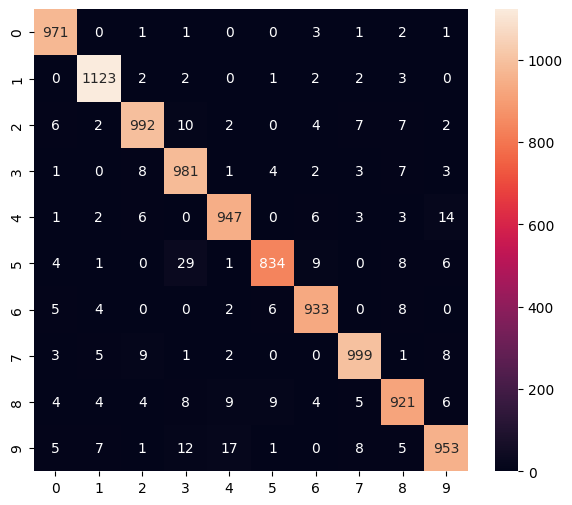

In [42]:
# %load solutions/MNIST/mlp_results.py
score_mlp = mlp.evaluate(x_test_flatten, y_test, verbose=0)
predict_mlp = mlp.predict(x_test_flatten)

print('Test loss:', score_mlp[0])
print('Test accuracy:', score_mlp[1])
print("Running time: %.2f seconds" %t_train_mlp)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predict_mlp.argmax(1))), annot=True, fmt="d")

In [ ]:
# %load solutions/MNIST/mlp_results.py

##### <i style="color:purple">**Question:** What can you say about these results?</i>

##### <i style="color:purple">**Exercise:** Normalize the data in order to have values between 0 and 1 and run again the learning.</i>

What can you say about these results?

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7800 - loss: 0.7398 - val_accuracy: 0.9432 - val_loss: 0.1911
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9341 - loss: 0.2218 - val_accuracy: 0.9596 - val_loss: 0.1331
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9520 - loss: 0.1599 - val_accuracy: 0.9589 - val_loss: 0.1240
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9615 - loss: 0.1280 - val_accuracy: 0.9710 - val_loss: 0.0945
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.1045 - val_accuracy: 0.9735 - val_loss: 0.0846
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9705 - loss: 0.0978 - val_accuracy: 0.9752 - val_loss: 0.0798
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9749 - loss: 0.0826 - val_accuracy: 0.9772 - val_loss: 0.0731
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9764 - loss: 0.0759 - val_accuracy: 0

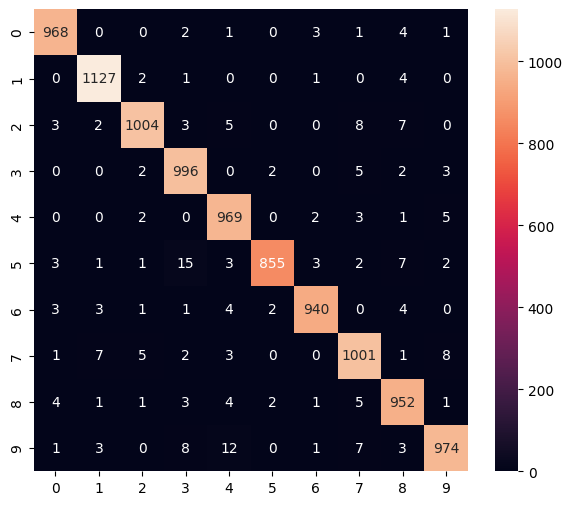

In [44]:
# %load solutions/MNIST/mlp_norm.py
batch_size = 256
epochs = 10

# Data normalization
x_train_flatten_norm = x_train.reshape((N_train, N_x_pixels*N_y_pixels))/255
x_test_flatten_norm = x_test.reshape((N_test, N_x_pixels*N_y_pixels))/255

# Network definition
mlp_norm = Sequential()
mlp_norm.add(Input(shape=(N_dim_flatten,)))
mlp_norm.add(Dense(128, activation='relu'))
mlp_norm.add(Dropout(0.2))
mlp_norm.add(Dense(128, activation='relu'))
mlp_norm.add(Dropout(0.2))
mlp_norm.add(Dense(N_classes, activation='softmax'))

# Network configuration
mlp_norm.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = RMSprop(),
            metrics = ['accuracy'])

# Network training
t_train_mlp_norm = time.time()
history_norm = mlp_norm.fit(x_train_flatten_norm, y_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 1,
                            validation_data = (x_test_flatten_norm, y_test))
t_train_mlp_norm = t_train_mlp_norm - time.time()

score_mlp_norm = mlp_norm.evaluate(x_test_flatten_norm, y_test, verbose=0)
predict_mlp_norm = mlp_norm.predict(x_test_flatten_norm)

# Results
print('Test loss:', score_mlp_norm[0])
print('Test accuracy:', score_mlp_norm[1])
print("Running time: %.2f seconds" %t_train_mlp_norm)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predict_mlp_norm.argmax(1))), annot=True, fmt="d")

In [ ]:
# %load solutions/MNIST/mlp_norm.py

## Convolutional Layers

In this part we will use convolution layers to build a convolutional classifier.

### Data format

The convolution architecture takes as input images and not 1D vectors. However, some data formating are still required.

A third dimension is required : the $\texttt{channels}$ dimension which will allow to describe each pixel. In our case this dimension's size is only 1 because the images are only defined with grey scale. However for colour images, each pixel is coded with several values (Images are generally encoded with 3 values (RGB channels)). 

Hence, we need to reshape the images from a $28\times28$ dimension to a $28\times28\times1$ dimension

In [45]:
x_train_conv = np.expand_dims(x_train, axis=-1)
x_test_conv = np.expand_dims(x_test, axis=-1)

print("Train data: %d images" %x_train_conv.shape[0], x_train_conv.shape[1:])
print("Test data: %d images" %x_test_conv.shape[0], x_test_conv.shape[1:])

Train data: 60000 images (28, 28, 1)
Test data: 10000 images (28, 28, 1)


### Edge detection

We will first check the transformation applied by a convolution layer.

In [46]:
from tensorflow.keras.layers import Conv2D

We select an example for each of the digits ($0$ to $9$), and define a new test image (a $+$) so that we can observe the effect of the convolution filters.
Try testing the proposed filters (or even others!) on different images, digit or plus.

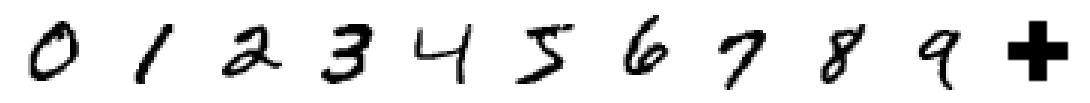

In [47]:
fig = plt.figure(figsize=(11, 5))

# Plus image test
img_plus = np.zeros((28,28), dtype=int)
img_plus[4:24,11:17] = 1
img_plus[11:17,4:24] = 1
img_plus = np.expand_dims(img_plus, axis=-1)

ax = fig.add_subplot(1, 11, 11)
ax.imshow(img_plus[:,:,0], cmap=plt.cm.gray_r)
ax.grid(False)
ax.axis('off')


# Digits
sample_index = np.zeros(10, dtype=int)
for i in range(10):
    sample_index[i] = np.where(y_train==i)[0][0]
    ax = fig.add_subplot(1, 11, i+1)
    ax.imshow(x_train[sample_index[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.grid(False)
    ax.axis('off')


plt.tight_layout()
plt.show()

Here are some examples of $3\times3$ convolution filters.

In [48]:
conv_filter_1 = np.array([
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
    ])

conv_filter_2 = 1/9 * np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
    ])

conv_filter_3 = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0],
    ])

conv_filter_4 = np.array([
        [-1, 2, -1],
        [-1, 2, -1],
        [-1, 2, -1],
    ])

conv_filter_5 = np.array([
        [-1, -1, 2],
        [-1, 2, -1],
        [2, -1, -1],
    ])

In the following code, we define a convolutional network with  only one filter for which we manually define the weights.

In [49]:
conv_filter = conv_filter_1

def my_init_filter(shape, conv_filter=conv_filter, dtype=None, partition_info=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
print(my_init_filter(0, conv_filter_2).shape)

conv_layer = Sequential()
conv_layer.add( Input(shape=(28, 28, 1)) )
conv_layer.add( Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter) )

(3, 3, 1, 1)


Note that in  $\texttt{my\_init\_filter}$ two dimensions have been added to the conv filter.

##### <i style="color:purple">**Question:** What do these dimensions represent?</i>

 The following codes allow to display the image, the filter and the convoluted image.

In [50]:
def build_conv_layer(conv_filter):    
    def my_init_filter(shape, conv_filter=conv_filter, dtype=None, partition_info=None):
        xf,yf = conv_filter.shape
        array = conv_filter.reshape(xf, yf, 1, 1)
        return array
    
    conv_layer = Sequential()
    conv_layer.add( Input(shape=(28, 28, 1)) )
    conv_layer.add( Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter) )
    return conv_layer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


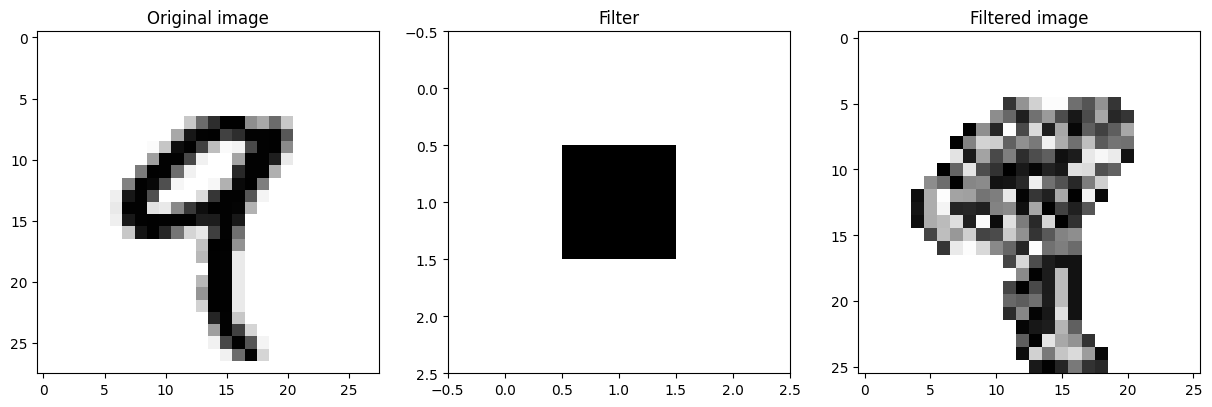

In [51]:
# CHOICES

# Image choice : Digit or Plus
idx = sample_index[9] #####
x = x_train_conv[idx] #####
# x = img_plus #####

# Filter choice
conv_filter = conv_filter_3 #####
conv_layer = build_conv_layer(conv_filter)

# --- #

img_in = np.expand_dims(x, 0)
img_out = conv_layer.predict(img_in)

# Original image
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap=plt.cm.gray_r)
ax0.set_title("Original image")
ax0.grid(False)

# Filter
norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap=plt.cm.gray_r)   # "binary"
ax1.set_title("Filter")
ax1.grid(False)

# Filtered image
ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap=plt.cm.gray_r)
ax2.set_title("Filtered image")
ax2.grid(False)

##### <i style="color:purple">**Question:** What do you see?</i>

* Are the output image coherent according to the designed filter ?
* How do the proposed filters affect the image?
* Change the code in order to test different filters (to detect horizontal edges, etc...)

### Strides and Padding

We will now study the effect on $\texttt{strides}$ and $\texttt{padding}$ arguments on the image.

$\texttt{padding}$ can take the values $\texttt{"same"}$ or $\texttt{"valid"}$. $\texttt{"valid"}$ means no padding.

In [52]:
def build_conv_layer_sp(conv_filter, strides=2, padding="same"):    
    def my_init_filter(shape, conv_filter=conv_filter, dtype=None, partition_info=None):
        xf,yf = conv_filter.shape
        array = conv_filter.reshape(xf, yf, 1, 1)
        return array
    
    conv_layer = Sequential()
    conv_layer.add( Input(shape=(28, 28, 1)) )
    conv_layer.add( Conv2D(kernel_size=(5,5), filters=1, kernel_initializer=my_init_filter,
                  strides=strides, padding=padding) )  ### NEW
    return conv_layer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


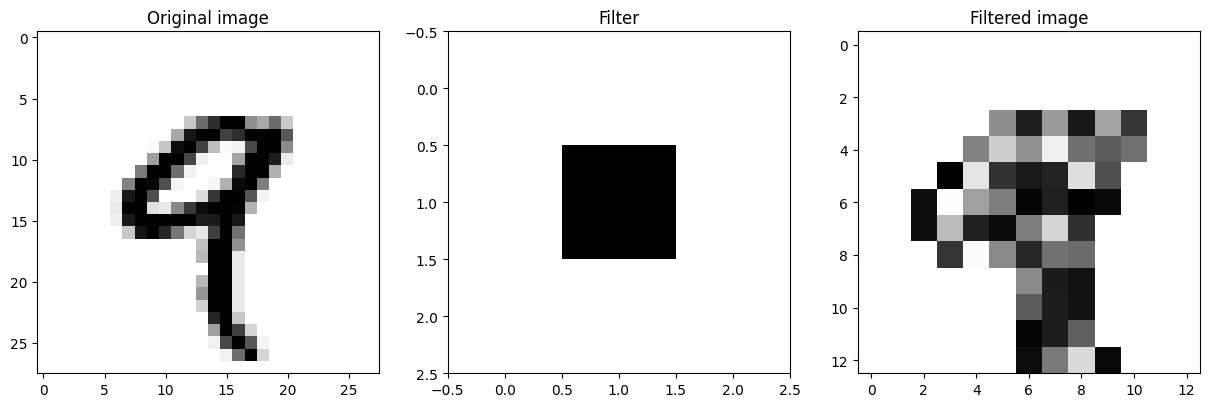

In [53]:
# CHOICES

# Image choice : Digit or Plus
idx = sample_index[9] #####
x = x_train_conv[idx] #####
# x = img_plus #####

# Filter choice
conv_filter = conv_filter_3 #####
conv_layer = build_conv_layer_sp(conv_filter, padding="valid")

# --- #

img_in = np.expand_dims(x, 0)
img_out = conv_layer.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8), cmap=plt.cm.gray_r);
ax0.set_title("Original image")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap=plt.cm.gray_r);
ax1.set_title("Filter")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap=plt.cm.gray_r);
ax2.set_title("Filtered image")
ax2.grid(False)

##### <i style="color:purple">**Question:** What do you see?</i>

* Check the dimension of the output images. Are they coherent? <br>
* Change both *strides* and *padding* arguments and understand the effect of these changes.

### Max Pooling

In [54]:
from tensorflow.keras.layers import MaxPool2D, MaxPooling2D

##### <i style="color:purple">**Exercise:** Write a similar code than above to check and understand the behaviour of the $\texttt{max pooling}$ layer.</i>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


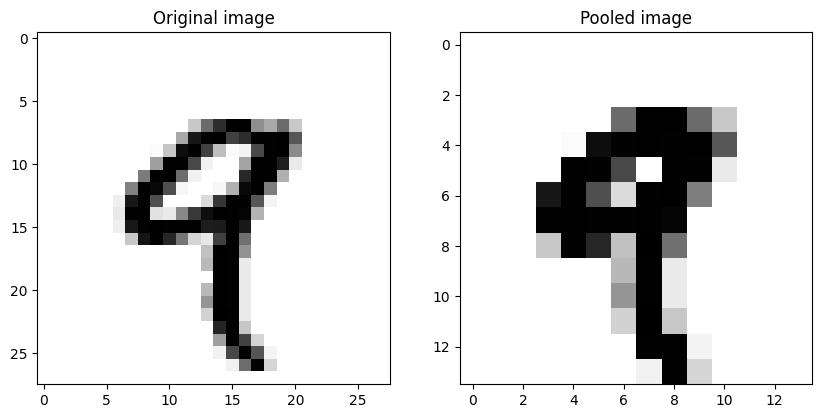

In [56]:
# %load solutions/MNIST/max_pooling.py
def build_pool_layer(pool_size=(2,2)):    
    def my_init_filter(shape, conv_filter=conv_filter, dtype=None, partition_info=None):
        xf,yf = conv_filter.shape
        array = conv_filter.reshape(xf, yf, 1, 1)
        return array
    
    pool_layer = Sequential()
    pool_layer.add( Input(shape=(28, 28, 1)) )
    pool_layer.add( MaxPool2D(pool_size=pool_size) )
    return pool_layer


# Image choice : Digit or Plus
idx = sample_index[9] #####
x = x_train_conv[idx] #####
# x = img_plus #####

pool_layer = build_pool_layer()

# --- #

img_in = np.expand_dims(x, 0)
img_out = pool_layer.predict(img_in)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8), cmap="binary");
ax0.set_title("Original image")
ax0.grid(False)

ax1.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary");
ax1.set_title("Pooled image")
ax1.grid(False)

In [ ]:
# %load solutions/MNIST/max_pooling.py

##### <i style="color:purple">**Question:** What are the dimension of the output image?</i>

## Convolutional Neural Network (CNN or ConvNet)

We will now build convolutional networks and see the performances on this kind of model on  image classification problems.

### LeNet5

We first test the  [LeNet5](https://en.wikipedia.org/wiki/LeNet) model, proposed by _LeCun et al._

In [82]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop

In [83]:
LeNet = Sequential()
LeNet.add(Input(shape=(28,28,1)))

LeNet.add(Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh'))
LeNet.add(MaxPool2D(pool_size = 2, strides = 2))

LeNet.add(Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
LeNet.add(MaxPool2D(pool_size = 2, strides = 2))

LeNet.add(Flatten())
LeNet.add(Dense(units = 120, activation = 'tanh'))
LeNet.add(Dense(units = 84, activation = 'tanh'))
LeNet.add(Dense(units = 10, activation = 'softmax'))

LeNet.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

##### <i style="color:purple">**Exercise:** Retrieve 'manually' the number of parameters of this model.</i>

What can you say about the total number of parameters compared with the MLP model defined before? Which layer has the highest number of parameters?

#### Training

In [84]:
batch_size=128
epochs=10

LeNet.compile(loss = "sparse_categorical_crossentropy",
              optimizer = RMSprop(),
              metrics = ['accuracy'])

t_train_LeNet = time.time()
LeNet.fit(x_train_conv, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test_conv, y_test))
t_train_LeNet = time.time() - t_train_LeNet

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8624 - loss: 0.4907 - val_accuracy: 0.9698 - val_loss: 0.0912
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9740 - loss: 0.0834 - val_accuracy: 0.9798 - val_loss: 0.0657
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9809 - loss: 0.0589 - val_accuracy: 0.9805 - val_loss: 0.0614
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9855 - loss: 0.0474 - val_accuracy: 0.9814 - val_loss: 0.0569
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0399 - val_accuracy: 0.9829 - val_loss: 0.0532
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9886 - loss: 0.0349 - val_accuracy: 0.9851 - val_loss: 0.0491
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9916 - loss: 0.0277 - val_accuracy: 0.9849 - val_loss: 0.0500
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0245 - val_accuracy: 0.

##### <i style="color:purple">**Question:** Why is the training time longer?</i>

##### <i style="color:purple">**Exercise:** Compare the accuracy with the one obtained with the optimizer $\texttt{Adam}$. </i>

#### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test loss: 0.05061386525630951
Test accuracy: 0.9846000075340271
Time Running: 17.02 seconds


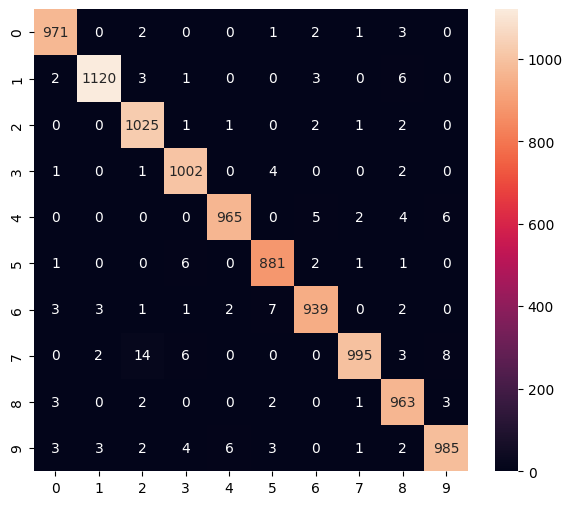

In [85]:
score_LeNet = LeNet.evaluate(x_test_conv, y_test, verbose=0)
predict_LeNet = LeNet.predict(x_test_conv)

print('Test loss:', score_LeNet[0])
print('Test accuracy:', score_LeNet[1])
print("Time Running: %.2f seconds" %t_train_LeNet )

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predict_LeNet.argmax(1))), annot=True, fmt="d")

### A more complex architecture


We will now design a more complex architecture to try to improve the results of the classification :

* A $\texttt{Conv2D}$ layer with $32 - 3\times3$ filters and the $\texttt{Relu}$ activation function,
* A $\texttt{Conv2D}$ layer with $64 - 3\times3$ filters and the $\texttt{Relu}$ activation function,
* A $\texttt{MaxPooling}$ layer with a $2\times2$ window,
* A $\texttt{Dropout}$ layer with a $25%$ drop rate,
* A $\texttt{Flatten}$ layer,
* A $\texttt{Dense}$ layer with $128$ neurons  and the $\texttt{Relu}$ activation function,
* A $\texttt{Dropout}$ layer with a $50\%$ drop rate,
* A $\texttt{Dense}$ layer with $10$ neurons  and the $\texttt{softmax}$ activation function.


##### <i style="color:purple">**Exercise:** Define this model and train it.</i>

In [68]:
# %load solutions/MNIST/cnn.py
# Network definition
ConvNet = Sequential()
ConvNet.add(Input(shape=(28,28, 1)))
ConvNet.add(Conv2D(32, kernel_size=(3, 3), activation='relu', data_format="channels_last"))
ConvNet.add(Conv2D(64, (3, 3), activation='relu'))
ConvNet.add(MaxPooling2D(pool_size=(2, 2)))
ConvNet.add(Dropout(0.25))
ConvNet.add(Flatten())
ConvNet.add(Dense(128, activation='relu'))
ConvNet.add(Dropout(0.5))
ConvNet.add(Dense(N_classes, activation='softmax'))
ConvNet.summary()

# Network configuration
ConvNet.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(),
              metrics = ['accuracy'])

# Network training
ts=time.time()
t_train_ConvNet = time.time()
ConvNet.fit(x_train_conv, y_train,
          batch_size = batch_size,
          epochs = 10,
          verbose = 1,
          validation_data = (x_test_conv, y_test))
te=time.time()
t_train_ConvNet = time.time() - t_train_ConvNet
t_train_conv = te-ts

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7212 - loss: 2.8774 - val_accuracy: 0.9780 - val_loss: 0.0762
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9519 - loss: 0.1649 - val_accuracy: 0.9822 - val_loss: 0.0599
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9662 - loss: 0.1167 - val_accuracy: 0.9875 - val_loss: 0.0383
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9735 - loss: 0.0892 - val_accuracy: 0.9866 - val_loss: 0.0417
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9766 - loss: 0.0765 - val_accuracy: 0.9889 - val_loss: 0.0399
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9782 - loss: 0.0695 - val_accuracy: 0.9889 - val_loss: 0.0381
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9802 - loss: 0.0630 - val_accuracy: 0.9880 - val_loss: 0.0391
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9791 - loss: 0.0645 - val_accuracy: 0

In [ ]:
# %load solutions/MNIST/cnn.py

##### <i style="color:purple">**Exercise:** Compare the accuracy with the one obtained with the optimizer Adam.</i>

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test loss: 0.03269050642848015
Test accuracy: 0.9911999702453613
Time Running: 31.04 seconds


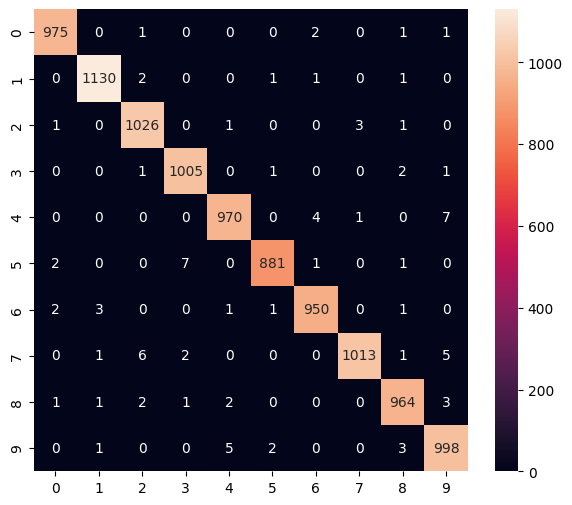

In [69]:
# %load solutions/MNIST/cnn_results.py
score_ConvNet = ConvNet.evaluate(x_test_conv, y_test, verbose=0)
predict_ConvNet = ConvNet.predict(x_test_conv)

print('Test loss:', score_ConvNet[0])
print('Test accuracy:', score_ConvNet[1])
print("Time Running: %.2f seconds" %t_train_ConvNet )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predict_ConvNet.argmax(1))), annot=True, fmt="d")

In [ ]:
# %load solutions/MNIST/cnn_results.py

##### <i style="color:purple">**Exercise:** Comment the results.</i>